# Natureness Image Recognition

Train and evaluation of multiple image recognition models on 2 datasets: city, nature.

## Goals

- Train models on 2 datasets: city, nature
- Evaluate models on 2 datasets: city, nature
- Compare the performance of the models on the 2 datasets, even with their respective evaluation datasets
- Train more image recognition models with transfer learning

In [29]:
import os
import glob
import wandb
import webp

from transformers import AutoImageProcessor, ConvNextModel
from sklearn.model_selection import train_test_split
import torch
import torchvision
import torchmetrics
from torch import nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np
from lightly.transforms import utils
from lightly.models.utils import deactivate_requires_grad
import lightning as l

In [14]:
wandb.login()

True

In [15]:
num_workers = os.cpu_count()
batch_size = 512
memory_bank_size = 4096
seed = 1
max_epochs = 100
data_dir = '..\data'
accelerator = "gpu" if torch.cuda.is_available() else "cpu"

torch.cuda.manual_seed_all(seed)

## Loading dataset

Labels are random for now, CHANGE it later!!

In [16]:
image_paths = glob.glob(os.path.join(data_dir, '**', '*.webp'), recursive=True)
x = np.array(image_paths)
print(len(x))
print(x[2], x[4561])

# until labels are available
y = np.random.uniform(low=0.0, high=1.0, size=(len(image_paths),))
print(len(y))
print(y[2], y[4561])

5980
..\data\data_v3\images\image_0002.webp ..\data\data_v4\images\image_2581.webp
5980
0.5682368882998279 0.9057349450570203


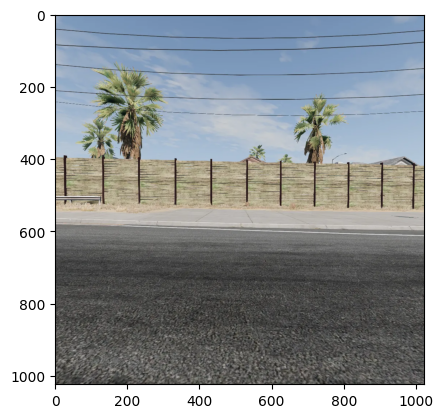

In [17]:
img = webp.load_image(x[2])
plt.imshow(img)

### Splitting dataset into train - validation - test sets

In [18]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5, random_state=42)

print("Train data:", x_train.shape, y_train.shape)
print("Test data:", x_test.shape, y_test.shape)
print("Validation data:", x_val.shape, y_val.shape)

Train data: (4784,) (4784,)
Test data: (598,) (598,)
Validation data: (598,) (598,)


In [19]:
class NaturnessDataset(Dataset):
    def __init__(self, x, y, transform=None, target_transform=None):
        self.image_paths = x
        self.labels = y
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = webp.load_image(self.image_paths[idx])
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [22]:
train_transforms = torchvision.transforms.Compose(
    [
        torchvision.transforms.RandomCrop(32, padding=4),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(
            mean=utils.IMAGENET_NORMALIZE["mean"],
            std=utils.IMAGENET_NORMALIZE["std"],
        ),
    ]
)

# No additional augmentations for the test set
test_transforms = torchvision.transforms.Compose(
    [
        torchvision.transforms.Resize((32, 32)),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(
            mean=utils.IMAGENET_NORMALIZE["mean"],
            std=utils.IMAGENET_NORMALIZE["std"],
        ),
    ]
)

dataset_train = NaturnessDataset(x_train, y_train, transform=train_transforms)
dataset_valid = NaturnessDataset(x_val, y_val, transform=test_transforms)
dataset_test = NaturnessDataset(x_test, y_test, transform=test_transforms)

In [23]:
dataloader_train = torch.utils.data.DataLoader(
    dataset_train,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers,
    persistent_workers=True,
)

dataloader_valid = torch.utils.data.DataLoader(
    dataset_valid,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers,
    persistent_workers=True,
)

dataloader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers,
    persistent_workers=True,
)

In [31]:
class NaturenessRegressionModel(l.LightningModule):
    def __init__(self, backbone, freeze, net):
        super().__init__()
        self.backbone = backbone

        if freeze:
            # freeze the backbone
            deactivate_requires_grad(backbone)

        # create a linear layer for downstream classification model
        self.fc = net

        self.criterion = nn.MSELoss()
        #self.accuracy = torchmetrics.Accuracy(task='multiclass', num_classes=num_classes)
        self.validation_step_outputs = []

    def forward(self, x):
        y_hat = self.backbone(x).flatten(start_dim=1)
        y_hat = self.fc(y_hat)
        return y_hat

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)
        loss = self.criterion(y_hat, y)
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)
        loss = self.criterion(y_hat, y)
        self.validation_step_outputs.append(loss)
        return loss

    def on_validation_epoch_end(self):
        if self.validation_step_outputs:
            avg_loss = np.mean(self.validation_step_outputs)
            self.log("val_loss", avg_loss)
            self.validation_step_outputs.clear()

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)
        loss = self.criterion(y_hat, y)
        self.log("test_loss", loss)
        return loss

    def predict_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        return (y_hat, y)

    def configure_optimizers(self):
        optim = torch.optim.Adam(self.fc.parameters(), lr=0.002884)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, max_epochs)
        return [optim], [scheduler]

In [ ]:
convnext_model = ConvNextModel.from_pretrained("facebook/convnext-tiny-224")
reg_layer = nn.Linear(768, 1)
reg_model = NaturenessRegressionModel(convnext_model, False, reg_layer)

'''
wandb_logger = pl.loggers.WandbLogger(
    name="backbone", project="Natureness Image Recognition"
)
callback = pl.callbacks.ModelCheckpoint(
    monitor='train_loss',
    mode='min',
    dirpath = '../ckpts/',
    filename = 'best_backbone',
)
'''

trainer = l.Trainer(
    max_epochs=2, devices=1, accelerator=accelerator, #logger=[wandb_logger], callbacks=[callback]
)
trainer.fit(model=reg_model, train_dataloaders=dataloader_train, val_dataloaders=dataloader_valid)

#wandb.finish()